In [12]:

import sys
sys.path.append('/home/scuk/RS/mujoco-py')
import mujoco_py
import safety_gym
import gym
from thinker import wrapper
import cv2
import numpy as np

env = gym.make('Safexp-PointGoal1-v0')
env = wrapper.DiscretizeActionWrapper(env)
env = wrapper.RepeatActionWrapper(env, frame_stack_n=4)
env.reset()
for _ in range(100):
    state, reward, done, info = env.step([5])
    if done: 
        env.reset()
        print("Done!")

In [1]:
from thinker.main import Env
from thinker.self_play import init_env_out, create_env_out
from thinker.actor_net import ActorNet
import thinker.util as util
import os
import torch

seed = 1
xpid = "v14_se_2"
savedir = "/home/scuk/RS/thinker/logs/thinker/"

ckpdir = os.path.join(savedir, xpid) 
config_path = os.path.join(ckpdir, 'config_c.yaml')
flags = util.create_flags(config_path, save_flags=False)
env = Env(
    name=flags.name,
    env_n=1,
    base_seed=seed,        
    gpu=False,
    train_model=False,
    parallel=False,
    savedir=savedir,        
    xpid=xpid,
    ckp=True,
    return_x=True,
    wrapper_type=3,
    se_query_size=5,
    se_query_cur=2,
    se_manual_sum=True,
    )
env.seed([0])
state = env.reset()

def create_env_(xpid):
    ckpdir = os.path.join(savedir, xpid) 
    config_path = os.path.join(ckpdir, 'config_c.yaml')
    flags = util.create_flags(config_path, save_flags=False)
    env_ = Env(
        name=flags.name,
        env_n=1,
        base_seed=seed,        
        gpu=False,
        train_model=False,
        parallel=False,
        savedir=savedir,        
        xpid=xpid,
        ckp=True,
        return_x=True,
        tree_carry=False,
        wrapper_type=0,
        )
    env_.model_net = env.model_net
    env_.seed([0])
    state_ = env_.reset()
    return env_, state_


Initializing env 0 with device cpu
Model network size: 6637133


Loaded config from /home/scuk/RS/thinker/logs/thinker/v14_se_2/config_c.yaml


Loaded model net from /home/scuk/RS/thinker/logs/thinker/v14_se_2/ckp_model.tar


Tree rep shape:  95
Tree rep meaning:  {'root_td': slice(0, 1, None), 'root_action': slice(1, 6, None), 'root_r': slice(6, 7, None), 'root_v': slice(7, 8, None), 'root_logits': slice(8, 13, None), 'cur_td': slice(13, 14, None), 'cur_action': slice(14, 19, None), 'cur_r': slice(19, 20, None), 'cur_v': slice(20, 21, None), 'cur_logits': slice(21, 26, None), 'cur_reset': slice(26, 27, None), 'one_hot_k': slice(27, 37, None), 'rollout_return': slice(37, 38, None), 'max_rollout_return': slice(38, 39, None), 'rollout_done': slice(39, 40, None), 'action_seq': slice(40, 65, None), 'root_query_results_mean_q_sa': slice(65, 70, None), 'root_query_results_max_q_sa': slice(70, 75, None), 'root_query_results_n_sa': slice(75, 80, None), 'cur_query_results_mean_q_sa': slice(80, 85, None), 'cur_query_results_max_q_sa': slice(85, 90, None), 'cur_query_results_n_sa': slice(90, 95, None)}


Initializing env 0 with device cpu
Model network size: 6637133
Loaded model net from /home/scuk/RS/thinker/logs/thinker/v14_se_2/ckp_model.tar


Loaded config from /home/scuk/RS/thinker/logs/thinker/v14_se_2/config_c.yaml


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


========================= STEP 0 =========================
new  root_td tensor([[-0.1009]])
new  root_action tensor([[1., 0., 0., 0., 0.]])
bas  root_action tensor([[1., 0., 0., 0., 0.]])
new  root_r tensor([[0.]])
bas  root_r tensor([[0.]])
new  root_v tensor([[3.3647]])
bas  root_v tensor([[3.3647]])
new  root_logits tensor([[-2.1379,  1.1944, -0.4179,  0.0064,  0.6162]])
bas  root_logits tensor([[-2.1379,  1.1944, -0.4179,  0.0064,  0.6162]])
new  cur_td tensor([[-1.2196]])
new  cur_action tensor([[0., 1., 0., 0., 0.]])
bas  cur_action tensor([[0., 1., 0., 0., 0.]])
new  cur_r tensor([[0.0055]])
bas  cur_r tensor([[0.0055]])
new  cur_v tensor([[2.2057]])
bas  cur_v tensor([[2.2057]])
new  cur_logits tensor([[-1.2850, -0.5031, -0.0099,  0.5044,  0.2601]])
bas  cur_logits tensor([[-1.2850, -0.5031, -0.0099,  0.5044,  0.2601]])
new  cur_reset tensor([[0.]])
bas  cur_reset tensor([[0.]])
new  one_hot_k tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])
new  rollout_return tensor([[2.145

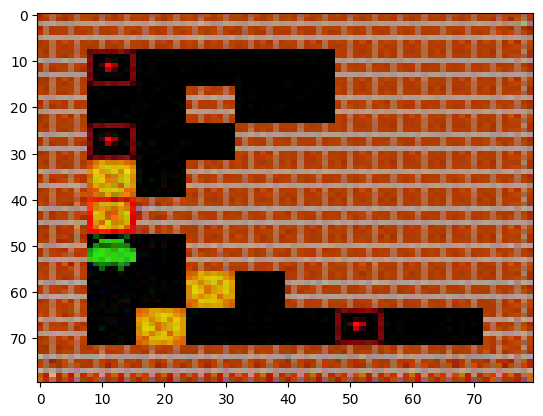

In [3]:
import numpy as np

def ckp_diff(x, y, name):
    assert torch.sum(torch.square(x.float()-y.float())) < 1e-8, \
            f"error for {name}, value new: {x}, value bas: {y}"

env.seed([0])
env.reset()
env_, state_ = create_env_(xpid)

pri = [np.random.randint(5) for _ in range(2000)]
res = [np.random.randint(2) for _ in range(2000)]

pri = [1, 1, 4, 4, 3, 4, 2, 1, 1]
res = [0, 1, 0, 1, 0, 1, 0, 0, 1]

#pri = [4, 4, 4, 4, 3, 3, 3, 1, 1, 3, 1, 1, 1, 1, 2, 2, 2, 2, 4, 2, 2, 3, 1, 1, 1, 1, 2, 2, 2, 2, 2, 4, 4, 4, 1, 3, 3, 2, 3, 1, 1, 0, 0, 0, 0, 0, 2]
#pri = np.repeat(pri, env.rep_rec_t)
#res = [np.random.randint(2) for _ in range(len(pri))]

print_txt = True
r_done = False
for m, (a, r) in enumerate(zip(pri, res)):
    state, reward, done, info = env.step(torch.tensor([a]), torch.tensor([r]))
    state_, reward_, done_, info_ = env_.step(torch.tensor([a]), torch.tensor([r]))
    real_step = info["step_status"][0] == 0
    if real_step: r_done = done
    if info["baseline"] is not None: print("baseline: ", info["baseline"], info_["baseline"])
    tr = env.decode_tree_reps(state['tree_reps'])
    tr_ = env_.decode_tree_reps(state_['tree_reps'])

    if m > 0: ckp_diff(info["im_reward"], info_["im_reward"], "im_reward")        
    if real_step: ckp_diff(state["real_states"], state_["real_states"], "real_states")        
    ckp_diff(reward, reward_, "reward")        
    ckp_diff(info["truncated_done"], info_["truncated_done"], "truncated_done")        
    ckp_diff(info["real_done"], info_["real_done"], "real_done")        

    #util.plot_raw_state(state['xs'][0])
    #util.plot_raw_state(state_['xs'][0])
    print(f"========================= STEP {m} =========================")
    for k, v in tr.items():
        if print_txt: print("new ", k, v)
        convert_table = {"root_topk_action": "root_ns", "topk_action": "cur_ns"}
        if k in convert_table:
            k_ = convert_table[k]
        else:
            k_ = k
        if k_ in tr_:
            if print_txt: print("bas ", k_, tr_[k_])
            if k_ == "action_seq": 
                v_ = tr_[k_][:, env.num_actions:]
            else:
                v_ = tr_[k_]
            if k_ == "cur_reset": continue
            if r_done and k_ in ["root_r", "cur_r"]: continue
            assert torch.sum(torch.square(v_-v)) < 1e-8, f"error for {k_} ({k}), value new: {v}, value bas: {v_}"

    for k, v in tr_.items():
        if k not in tr:
            if print_txt: print("bas ", k, tr_[k])
util.plot_raw_state(state['xs'][0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


bas  root_td tensor([[-0.1009]])
bas  root_action tensor([[1., 0., 0., 0., 0.]])
bas  root_r tensor([[0.]])
bas  root_v tensor([[3.3647]])
bas  root_logits tensor([[-2.1379,  1.1944, -0.4179,  0.0064,  0.6162]])
bas  cur_td tensor([[-1.2196]])
bas  cur_action tensor([[0., 1., 0., 0., 0.]])
bas  cur_r tensor([[0.0055]])
bas  cur_v tensor([[2.2057]])
bas  cur_logits tensor([[-1.2850, -0.5031, -0.0099,  0.5044,  0.2601]])
bas  cur_reset tensor([[0.]])
bas  one_hot_k tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])
bas  rollout_return tensor([[2.1450]])
bas  max_rollout_return tensor([[3.3755]])
bas  rollout_done tensor([[0.]])
bas  action_seq tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.]])
bas  root_topk_similarity tensor([[ 1.0000,  1.0000,  1.0000,  1.0000,  0.9837,  0.9419,  0.9281,  0.9048,
         -1.0000, -1.0000]])
bas  root_topk_td tensor([[3.3647, 2.5594, 3.3647, 3.2695, 3.3666]])


RuntimeError: shape '[10, 1, 5]' is invalid for input of size 5

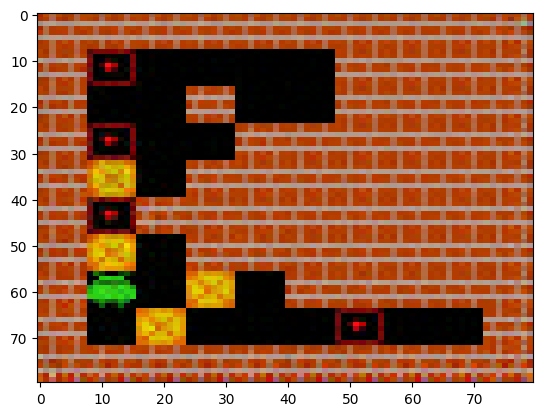

In [3]:
import numpy as np

pri = [np.random.randint(5)]
pri = [1]
res = [np.random.randint(2)]
res = [0]

for a, r in zip(pri, res):
    state, reward, done, info = env.step(torch.tensor([a]), torch.tensor([r]))
    tr = env.decode_tree_reps(state['tree_reps'])    

    util.plot_raw_state(state['xs'][0])
    for k, v in tr.items():
        v = tr[k]
        if "topk_action" in k or "root_action_table" == k:
            v = torch.sum(v.view(env.query_size, env.dim_actions, env.num_actions) * torch.arange(env.num_actions, device=v.device), dim=-1)
            v = v[:, 0]
        print("bas ", k, v)
    print(info["cost"])


3


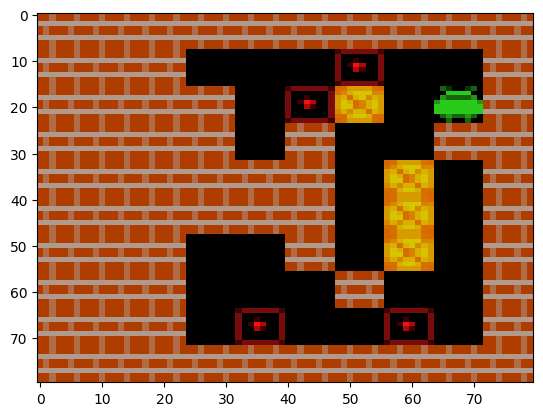

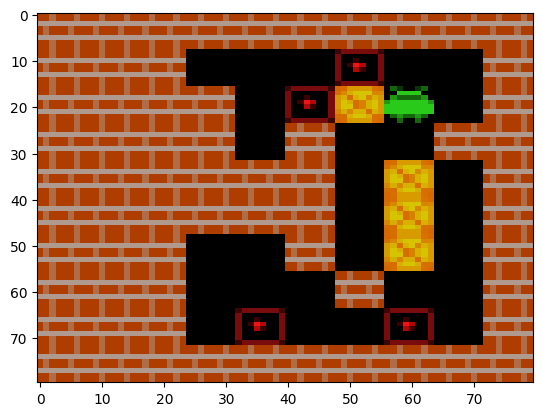

In [37]:
b = 3
t = -2

s_t = d['real_state'][t, b]
a_t = d['action'][t + 1, b]
s_t1 = d['real_state'][t + 1, b]

util.plot_raw_state(torch.tensor(s_t))
util.plot_raw_state(torch.tensor(s_t1))
print(a_t)